In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df=pd.read_csv('./data/regenerated_landslide_risk_dataset.csv')

In [4]:
df.head()

,Temperature (°C),Humidity (%),Precipitation (mm),Soil Moisture (%),Elevation (m),Landslide Risk Prediction
0,17,68,176,64,120,Low
1,26,33,65,24,672,Low
2,16,81,56,52,36,Low
3,25,53,136,70,583,Low
4,34,77,23,37,130,Low


In [5]:
df['Landslide Risk Prediction'].value_counts()

Landslide Risk Prediction
Low          4591
Moderate      334
High           63
Very High      12
Name: count, dtype: int64

In [6]:
df.shape

(5000, 6)

In [7]:
df.columns

Index(['Temperature (°C)', 'Humidity (%)', 'Precipitation (mm)',
       'Soil Moisture (%)', 'Elevation (m)', 'Landslide Risk Prediction'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Temperature (°C)           5000 non-null   int64 
 1   Humidity (%)               5000 non-null   int64 
 2   Precipitation (mm)         5000 non-null   int64 
 3   Soil Moisture (%)          5000 non-null   int64 
 4   Elevation (m)              5000 non-null   int64 
 5   Landslide Risk Prediction  5000 non-null   object
dtypes: int64(5), object(1)
memory usage: 234.5+ KB


In [9]:

# Basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nClass Distribution:")
print(df['Landslide Risk Prediction'].value_counts())

Dataset Shape: (5000, 6)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Temperature (°C)           5000 non-null   int64 
 1   Humidity (%)               5000 non-null   int64 
 2   Precipitation (mm)         5000 non-null   int64 
 3   Soil Moisture (%)          5000 non-null   int64 
 4   Elevation (m)              5000 non-null   int64 
 5   Landslide Risk Prediction  5000 non-null   object
dtypes: int64(5), object(1)
memory usage: 234.5+ KB
None

First 5 rows:
   Temperature (°C)  Humidity (%)  Precipitation (mm)  Soil Moisture (%)  \
0                17            68                 176                 64   
1                26            33                  65                 24   
2                16            81                  56                 52   
3                25            53     

In [10]:
print('\n Missing values are: ')
print(df.isnull().sum())


 Missing values are: 
Temperature (°C)             0
Humidity (%)                 0
Precipitation (mm)           0
Soil Moisture (%)            0
Elevation (m)                0
Landslide Risk Prediction    0
dtype: int64


In [11]:
## Statistical Summary
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
       Temperature (°C)  Humidity (%)  Precipitation (mm)  Soil Moisture (%)  \
count       5000.000000   5000.000000         5000.000000        5000.000000   
mean          24.815800     62.614000          123.126400          54.915800   
std            6.052867     19.108533           72.144734          20.345788   
min           15.000000     30.000000            0.000000          20.000000   
25%           20.000000     46.000000           61.000000          37.000000   
50%           25.000000     63.000000          121.000000          55.000000   
75%           30.000000     79.000000          186.000000          72.250000   
max           35.000000     95.000000          250.000000          90.000000   

       Elevation (m)  
count    5000.000000  
mean      503.015800  
std       288.700745  
min         0.000000  
25%       253.000000  
50%       505.000000  
75%       757.000000  
max      1000.000000  


In [12]:

# Visualizations
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

([0, 1, 2, 3],
 [Text(0, 0, 'Low'),
  Text(1, 0, 'Moderate'),
  Text(2, 0, 'High'),
  Text(3, 0, 'Very High')])

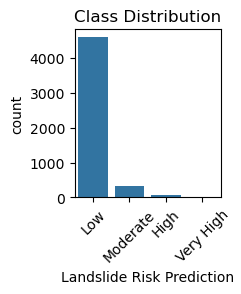

In [13]:
# Class distribution
plt.subplot(2, 3, 1)
sns.countplot(x='Landslide Risk Prediction', data=df)
plt.title('Class Distribution')
plt.xticks(rotation=45)

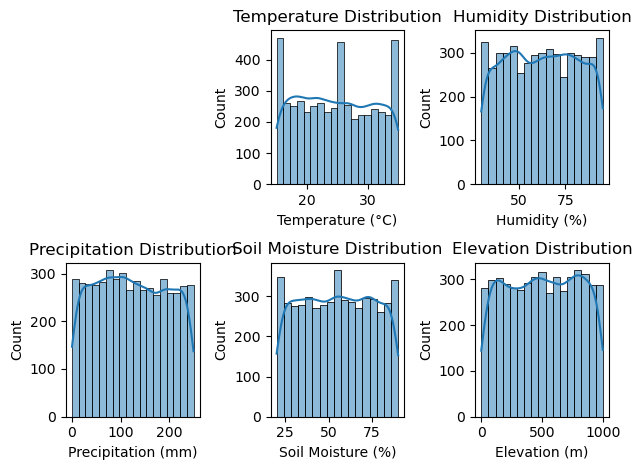

In [14]:
# Feature distributions
plt.subplot(2, 3, 2)
sns.histplot(df['Temperature (°C)'], kde=True)
plt.title('Temperature Distribution')

plt.subplot(2, 3, 3)
sns.histplot(df['Humidity (%)'], kde=True)
plt.title('Humidity Distribution')

plt.subplot(2, 3, 4)
sns.histplot(df['Precipitation (mm)'], kde=True)
plt.title('Precipitation Distribution')

plt.subplot(2, 3, 5)
sns.histplot(df['Soil Moisture (%)'], kde=True)
plt.title('Soil Moisture Distribution')

plt.subplot(2, 3, 6)
sns.histplot(df['Elevation (m)'], kde=True)
plt.title('Elevation Distribution')

plt.tight_layout()
plt.savefig('feature_distributions.png')

plt.show()

In [15]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr = df.iloc[:, :-1].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.close()

In [16]:

# Feature relationships with target
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(df.columns[:-1]):
    if i < 4:  # Plot first 4 features
        sns.boxplot(x='Landslide Risk Prediction', y=feature, data=df, ax=axes[i])
        axes[i].set_title(f'{feature} vs Landslide Risk')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('feature_vs_target.png')
plt.close()


/var/folders/1f/rff5j6dx6wqbh_t1yts0t1nm0000gn/T/ipykernel_2338/1765229272.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/var/folders/1f/rff5j6dx6wqbh_t1yts0t1nm0000gn/T/ipykernel_2338/1765229272.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/var/folders/1f/rff5j6dx6wqbh_t1yts0t1nm0000gn/T/ipykernel_2338/1765229272.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/var/folders/1f/rff5j6dx6wqbh_t1yts0t1nm0000gn/T/ipykernel_2338/1765229272.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set

## Key Takeaways:

1. Humidity, precipitation, and soil moisture are positively correlated with landslide risk.

2. Temperature does not show a strong correlation with landslide risk.

3. Higher landslide risk is associated with high humidity, high precipitation, and high soil moisture levels.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Separate features and target
X = df.iloc[:, :-1]
y = df['Landslide Risk Prediction']

In [19]:
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{y.value_counts()}")

Dataset shape: (5000, 6)
Class distribution:
Landslide Risk Prediction
Low          4591
Moderate      334
High           63
Very High      12
Name: count, dtype: int64


In [20]:
# Split the data with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

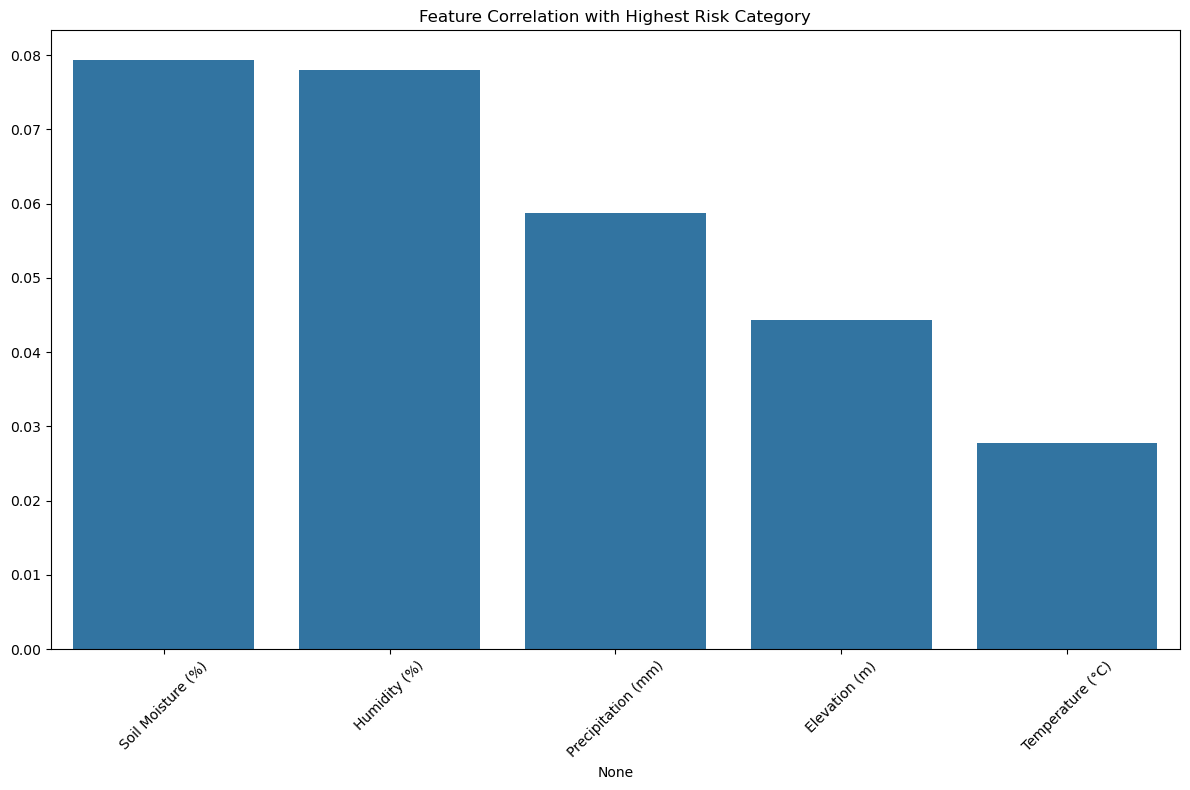

In [21]:
# Create visualization for feature importance after EDA
plt.figure(figsize=(12, 8))
corr = X.corrwith(pd.get_dummies(y, drop_first=True).iloc[:, -1]).sort_values(ascending=False)
sns.barplot(x=corr.index, y=corr.values)
plt.title('Feature Correlation with Highest Risk Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('feature_correlation.png')
plt.close()

In [22]:
print("Building model pipelines...")

Building model pipelines...


In [23]:
# Create a preprocessing and model pipeline with SMOTE
rf_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

gb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [28]:
# Define parameter grids for hyperparameter tuning
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None]
}

gb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

In [29]:
# Use stratified k-fold to maintain class distribution during CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
# Define scoring metric that works well for imbalanced data
scoring = 'f1_weighted'

# Perform hyperparameter tuning with RandomForest
print("Starting RandomForest hyperparameter tuning...")
rf_grid = GridSearchCV(
    rf_pipeline, 
    rf_param_grid, 
    cv=skf, 
    scoring=scoring, 
    n_jobs=-1, 
    verbose=1
)
rf_grid.fit(X_train, y_train)

print(f"Best RandomForest parameters: {rf_grid.best_params_}")
print(f"Best RandomForest CV score: {rf_grid.best_score_:.4f}")

# Perform hyperparameter tuning with GradientBoosting
print("Starting GradientBoosting hyperparameter tuning...")
gb_grid = GridSearchCV(
    gb_pipeline, 
    gb_param_grid, 
    cv=skf, 
    scoring=scoring, 
    n_jobs=-1, 
    verbose=1
)
gb_grid.fit(X_train, y_train)

print(f"Best GradientBoosting parameters: {gb_grid.best_params_}")
print(f"Best GradientBoosting CV score: {gb_grid.best_score_:.4f}")

Starting RandomForest hyperparameter tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best RandomForest parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Best RandomForest CV score: 0.9955
Starting GradientBoosting hyperparameter tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best GradientBoosting parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best GradientBoosting CV score: 0.9984


In [31]:
# Select the best model based on CV scores
if rf_grid.best_score_ > gb_grid.best_score_:
    best_model = rf_grid.best_estimator_
    model_name = "RandomForest"
    best_params = rf_grid.best_params_
else:
    best_model = gb_grid.best_estimator_
    model_name = "GradientBoosting"
    best_params = gb_grid.best_params_

print(f"Best model selected: {model_name}")

Best model selected: GradientBoosting


In [32]:
# Evaluate on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

In [33]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


===== Model Evaluation =====
Accuracy: 1.0000
F1 Score (weighted): 1.0000

Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        13
         Low       1.00      1.00      1.00       918
    Moderate       1.00      1.00      1.00        67
   Very High       1.00      1.00      1.00         2

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Confusion Matrix:
[[ 13   0   0   0]
 [  0 918   0   0]
 [  0   0  67   0]
 [  0   0   0   2]]


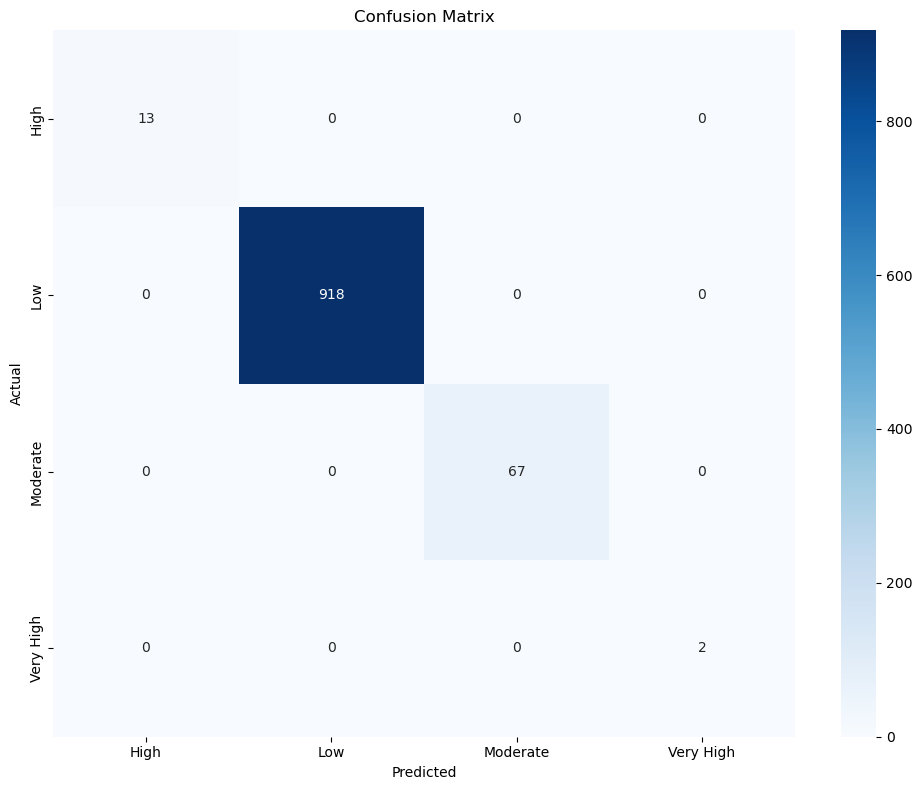

In [34]:
# Print evaluation results
print("\n===== Model Evaluation =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), 
            yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.savefig('confusion_matrix.png')
plt.close()

In [35]:
# Get feature importances for the best model
if model_name == "RandomForest":
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance (RandomForest)')
    plt.tight_layout()
    plt.show()
    plt.savefig('feature_importance_rf.png')
    plt.close()
    
    print("\nFeature Importance:")
    print(feature_importance)

In [36]:
# Save the best model, pipeline, and scaler
joblib.dump(best_model, 'landslide_model_tuned.pkl')

# Extract the scaler from the pipeline for future use with streaming data
scaler = best_model.named_steps['scaler']
joblib.dump(scaler, 'scaler.pkl')

print("\nModel and scaler saved to disk.")
print(f"Best model parameters: {best_params}")


Model and scaler saved to disk.
Best model parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}


In [37]:
# Create a model explanation function that can be used for real-time predictions
def explain_prediction(features, prediction, probabilities):
    """Generate an explanation for landslide risk prediction."""
    feature_names = ['Temperature', 'Humidity', 'Precipitation', 'Soil Moisture', 'Elevation']
    top_factors = []
    
    # Get feature importance from the model
    if model_name == "RandomForest":
        importances = best_model.named_steps['classifier'].feature_importances_
    else:
        importances = best_model.named_steps['classifier'].feature_importances_
    
    # Sort features by importance
    sorted_idx = np.argsort(importances)[::-1]
    
    # Get the top 3 important features
    for i in sorted_idx[:3]:
        feature_name = feature_names[i]
        value = features[i]
        
        # Check if feature value is high or low relative to averages from training data
        if feature_name == 'Humidity' and value > 80:
            top_factors.append(f"High humidity ({value}%)")
        elif feature_name == 'Precipitation' and value > 150:
            top_factors.append(f"High precipitation ({value}mm)")
        elif feature_name == 'Soil Moisture' and value > 80:
            top_factors.append(f"High soil moisture ({value}%)")
        elif feature_name == 'Elevation' and value > 700:
            top_factors.append(f"High elevation ({value}m)")
    
    # Create explanation based on prediction
    risk_level = prediction
    
    if risk_level == 'Low':
        explanation = f"The landslide risk is LOW. Main factors: {', '.join(top_factors)}"
    elif risk_level == 'Moderate':
        explanation = f"The landslide risk is MODERATE. Please monitor conditions. Main factors: {', '.join(top_factors)}"
    elif risk_level == 'High':
        explanation = f"WARNING: The landslide risk is HIGH. Prepare for possible evacuation. Main factors: {', '.join(top_factors)}"
    else:  # Very High
        explanation = f"DANGER: The landslide risk is VERY HIGH. Immediate evacuation recommended! Main factors: {', '.join(top_factors)}"
    
    # Add probability information
    max_prob = max(probabilities)
    explanation += f" (Confidence: {max_prob:.1%})"
    
    return explanation

In [38]:
# Test the explanation function
sample_features = X_test.iloc[0].values
sample_prediction = y_pred[0]
sample_probabilities = y_pred_proba[0]
print("\nSample Prediction Explanation:")
print(explain_prediction(sample_features, sample_prediction, sample_probabilities))


Sample Prediction Explanation:
The landslide risk is LOW. Main factors:  (Confidence: 100.0%)


In [40]:

# Save the explanation function
with open('explanation_function.py', 'w') as f:
    f.write("import numpy as np\n\n")
    f.write("def explain_prediction(features, prediction, probabilities):\n")
    f.write("    \"\"\"Generate an explanation for landslide risk prediction.\"\"\"\n")
    f.write("    # Code from the explain_prediction function\n")
    f.write("    feature_names = ['Temperature', 'Humidity', 'Precipitation', 'Soil Moisture', 'Elevation']\n")
    f.write("    top_factors = []\n\n")
    f.write("    # Your model's feature importances\n")
    # f.write("    importances = " + str(importances.tolist()) + "\n\n")
    f.write("    # Sort features by importance\n")
    f.write("    sorted_idx = np.argsort(importances)[::-1]\n\n")
    f.write("    # Get the top 3 important features\n")
    f.write("    for i in sorted_idx[:3]:\n")
    f.write("        feature_name = feature_names[i]\n")
    f.write("        value = features[i]\n\n")
    f.write("        # Check if feature value is high or low relative to averages\n")
    f.write("        if feature_name == 'Humidity' and value > 80:\n")
    f.write("            top_factors.append(f\"High humidity ({value}%)\")\n")
    f.write("        elif feature_name == 'Precipitation' and value > 150:\n")
    f.write("            top_factors.append(f\"High precipitation ({value}mm)\")\n")
    f.write("        elif feature_name == 'Soil Moisture' and value > 80:\n")
    f.write("            top_factors.append(f\"High soil moisture ({value}%)\")\n")
    f.write("        elif feature_name == 'Elevation' and value > 700:\n")
    f.write("            top_factors.append(f\"High elevation ({value}m)\")\n\n")
    f.write("    # Create explanation based on prediction\n")
    f.write("    risk_level = prediction\n\n")
    f.write("    if risk_level == 'Low':\n")
    f.write("        explanation = f\"The landslide risk is LOW. Main factors: {', '.join(top_factors)}\"\n")
    f.write("    elif risk_level == 'Moderate':\n")
    f.write("        explanation = f\"The landslide risk is MODERATE. Please monitor conditions. Main factors: {', '.join(top_factors)}\"\n")
    f.write("    elif risk_level == 'High':\n")
    f.write("        explanation = f\"WARNING: The landslide risk is HIGH. Prepare for possible evacuation. Main factors: {', '.join(top_factors)}\"\n")
    f.write("    else:  # Very High\n")
    f.write("        explanation = f\"DANGER: The landslide risk is VERY HIGH. Immediate evacuation recommended! Main factors: {', '.join(top_factors)}\"\n\n")
    f.write("    # Add probability information\n")
    f.write("    max_prob = max(probabilities)\n")
    f.write("    explanation += f\" (Confidence: {max_prob:.1%})\"\n\n")
    f.write("    return explanation\n")

print("Explanation function saved to 'explanation_function.py'")
print("Model building and evaluation completed.")


Explanation function saved to 'explanation_function.py'
Model building and evaluation completed.


In [24]:
rf=RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [25]:
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

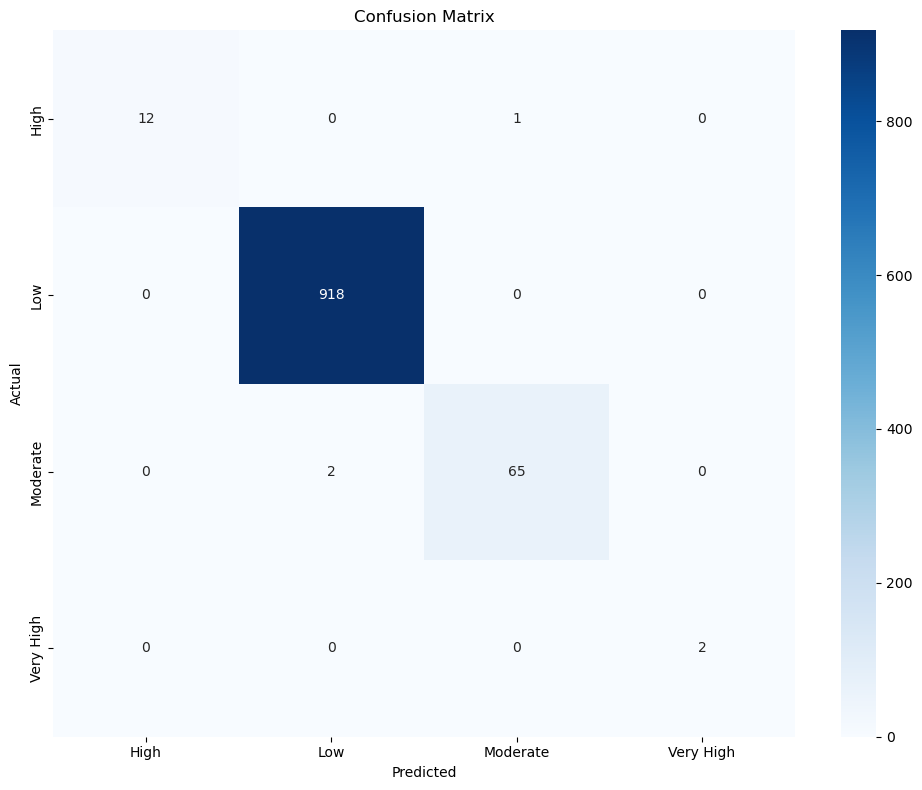

In [26]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), 
            yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [27]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')


In [28]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 0.9970
F1 Score (weighted): 0.9970
ROC AUC: 1.0000


In [29]:
## Handle the imbalanced dataset
from imblearn.over_sampling import SMOTE
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [ ]:
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
y_pred_proba = rf_pipeline.predict_proba(X_test)


TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't